# Product Purchasing Behavior by Demographics

This notebook analyzes how product purchasing patterns vary across different demographic segments, focusing on income levels, presence of children, and age groups to identify targeted marketing opportunities.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from completejourney_py import get_data

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Load required datasets
data = get_data(["transactions", "demographics", "products"])
transactions = data["transactions"]
demographics = data["demographics"]
products = data["products"]

print(f"Loaded {len(transactions):,} transaction records")
print(f"Loaded {len(demographics):,} household demographic records")
print(f"Loaded {len(products):,} product records")

# Show data coverage
transaction_households = set(transactions['household_id'])
demo_households = set(demographics['household_id'])
overlap = transaction_households.intersection(demo_households)

print(f"\nData Coverage:")
print(f"Households with transactions: {len(transaction_households):,}")
print(f"Households with demographics: {len(demo_households):,}")
print(f"Households with both: {len(overlap):,}")
print(f"Coverage rate: {len(overlap)/len(transaction_households)*100:.1f}%")

Loaded 1,469,307 transaction records
Loaded 801 household demographic records
Loaded 92,331 product records

Data Coverage:
Households with transactions: 2,469
Households with demographics: 801
Households with both: 801
Coverage rate: 32.4%


## Data Preparation: Create Demographic Segments

In [3]:
# Clean and prepare demographic data
demo_clean = demographics.copy()

# Create kids indicator (kids_count != '0')
demo_clean['has_kids'] = demo_clean['kids_count'] != '0'
demo_clean['kids_category'] = demo_clean['has_kids'].map({True: 'With Kids', False: 'No Kids'})

# Create simplified income groups based on actual income categories
def categorize_income(income):
    if pd.isna(income):
        return 'Unknown'
    
    income_mapping = {
        'Under 15K': 'Low Income',
        '15-24K': 'Low Income', 
        '25-34K': 'Low Income',
        '35-49K': 'Middle Income',
        '50-74K': 'Middle Income',
        '75-99K': 'Middle Income',
        '100-124K': 'High Income',
        '125-149K': 'High Income',
        '150-174K': 'High Income',
        '175-199K': 'High Income',
        '200-249K': 'High Income',
        '250K+': 'High Income'
    }
    return income_mapping.get(income, 'Unknown')

demo_clean['income_group'] = demo_clean['income'].apply(categorize_income)

# Create simplified age groups based on actual age categories
def categorize_age(age):
    if pd.isna(age):
        return 'Unknown'
    
    age_mapping = {
        '19-24': 'Young Adults (19-34)',
        '25-34': 'Young Adults (19-34)',
        '35-44': 'Middle-aged (35-54)', 
        '45-54': 'Middle-aged (35-54)',
        '55-64': 'Older Adults (55+)',
        '65+': 'Older Adults (55+)'
    }
    return age_mapping.get(age, 'Unknown')

demo_clean['age_group'] = demo_clean['age'].apply(categorize_age)

# Display demographic distributions
print("Demographic Segment Distributions:")
print("\nIncome Groups:")
print(demo_clean['income_group'].value_counts())
print("\nAge Groups:")
print(demo_clean['age_group'].value_counts())
print("\nKids Categories:")
print(demo_clean['kids_category'].value_counts())

Demographic Segment Distributions:

Income Groups:
income_group
Middle Income    460
Low Income       212
High Income      129
Name: count, dtype: int64

Age Groups:
age_group
Middle-aged (35-54)     482
Young Adults (19-34)    188
Older Adults (55+)      131
Name: count, dtype: int64

Kids Categories:
kids_category
No Kids      513
With Kids    288
Name: count, dtype: int64


## Product Purchase Analysis by Demographics

In [4]:
# Create combined transaction-demographic dataset
transaction_demo = (
    transactions
    .merge(demo_clean[['household_id', 'income_group', 'age_group', 'kids_category']], 
           on='household_id', how='inner')
    .merge(products[['product_id', 'product_category', 'department', 'brand']], 
           on='product_id', how='left')
)

print(f"Combined dataset: {len(transaction_demo):,} transactions")
print(f"Households with complete data: {transaction_demo['household_id'].nunique():,}")

# Filter out coupon/misc items and other non-meaningful categories for demographic analysis
excluded_categories = [
    'COUPON/MISC ITEMS', 
    'MISCELLANEOUS',
    'COUPON',
    'MISC ITEMS',
    'PHARMACEUTICAL',
    'RX CLAIMS'
]

# Filter to actual consumer products only
consumer_transactions = transaction_demo[
    ~transaction_demo['product_category'].isin(excluded_categories)
].copy()

print(f"After filtering out coupons/misc: {len(consumer_transactions):,} transactions")
print(f"Unique product categories: {consumer_transactions['product_category'].nunique():,}")

# Calculate product popularity by sales value (more meaningful than quantity for demographics)
product_popularity = (
    consumer_transactions
    .groupby(['product_id', 'product_category', 'department', 'brand'])
    .agg({
        'quantity': 'sum',
        'sales_value': 'sum',
        'household_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'household_id': 'unique_households'})
    .sort_values('sales_value', ascending=False)  # Sort by sales value instead of quantity
)

print(f"\nTop 10 Most Purchased Products (by sales value):") 
n = 0
for i, row in product_popularity.head(10).iterrows():
    n += 1
    print(f"{n:2d}. {row['product_category']} ({row['brand']}) - {row['department']}")
    print(f"    Sales: ${row['sales_value']:,.0f} | Households: {row['unique_households']:,} | Quantity: {row['quantity']:,}")

# Also show top categories by penetration (number of households)
category_popularity = (
    consumer_transactions
    .groupby('product_category')
    .agg({
        'sales_value': 'sum',
        'household_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'household_id': 'unique_households'})
    .sort_values('unique_households', ascending=False)
)

print(f"\nTop 10 Product Categories by Household Penetration:")
n = 0
for i, row in category_popularity.head(10).iterrows():
    n += 1
    print(f"{n:2d}. {row['product_category']}: {row['unique_households']:,} households (${row['sales_value']:,.0f})")

Combined dataset: 828,850 transactions
Households with complete data: 801
After filtering out coupons/misc: 818,433 transactions
Unique product categories: 296

Top 10 Most Purchased Products (by sales value):
 1. FLUID MILK PRODUCTS (Private) - GROCERY
    Sales: $12,557 | Households: 424 | Quantity: 5,100
 2. TROPICAL FRUIT (National) - PRODUCE
    Sales: $10,445 | Households: 736 | Quantity: 10,722
 3. FUEL (Private) - FUEL
    Sales: $10,059 | Households: 117 | Quantity: 572
 4. CHICKEN (National) - MEAT
    Sales: $9,844 | Households: 415 | Quantity: 2,384
 5. FLUID MILK PRODUCTS (Private) - GROCERY
    Sales: $8,526 | Households: 471 | Quantity: 7,208
 6. BERRIES (National) - PRODUCE
    Sales: $7,614 | Households: 504 | Quantity: 3,459
 7. FLUID MILK PRODUCTS (Private) - GROCERY
    Sales: $7,449 | Households: 291 | Quantity: 3,025
 8. SOFT DRINKS (National) - GROCERY
    Sales: $7,444 | Households: 337 | Quantity: 2,419
 9. BEEF (National) - MEAT
    Sales: $6,366 | Households:

## Product Preferences by Income Level

In [5]:
# Analyze product preferences by income group
income_product_analysis = (
    consumer_transactions[consumer_transactions['income_group'] != 'Unknown']
    .groupby(['income_group', 'product_category'])
    .agg({
        'quantity': 'sum',
        'sales_value': 'sum',
        'household_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'household_id': 'unique_households'})
)

# Calculate category penetration by income group
income_totals = (
    consumer_transactions[consumer_transactions['income_group'] != 'Unknown']
    .groupby('income_group')['household_id']
    .nunique()
    .reset_index()
    .rename(columns={'household_id': 'total_households'})
)

income_product_analysis = income_product_analysis.merge(income_totals, on='income_group')
income_product_analysis['penetration_rate'] = (
    income_product_analysis['unique_households'] / income_product_analysis['total_households'] * 100
)

# Find top categories by income group
print("Top 5 Product Categories by Income Group (by penetration rate):")
print("=" * 80)

for income_group in ['Low Income', 'Middle Income', 'High Income']:
    print(f"\n{income_group}:")
    income_data = income_product_analysis[income_product_analysis['income_group'] == income_group]
    top_categories = income_data.nlargest(5, 'penetration_rate')
    
    for i, row in top_categories.iterrows():
        print(f" - {row['product_category']}: {row['penetration_rate']:.1f}% penetration ({row['unique_households']} households)")

# Analyze spending per household by income
income_spending = (
    consumer_transactions[consumer_transactions['income_group'] != 'Unknown']
    .groupby(['income_group', 'household_id'])
    .agg({
        'sales_value': 'sum',
        'quantity': 'sum'
    })
    .reset_index()
    .groupby('income_group')
    .agg({
        'sales_value': ['mean', 'median'],
        'quantity': ['mean', 'median']
    })
    .round(2)
)

income_spending.columns = ['_'.join(col) for col in income_spending.columns]
print(f"\n\nSpending Patterns by Income Group:")
display(income_spending)

Top 5 Product Categories by Income Group (by penetration rate):

Low Income:
 - SOFT DRINKS: 99.5% penetration (211 households)
 - BAKED BREAD/BUNS/ROLLS: 98.6% penetration (209 households)
 - CHEESE: 98.1% penetration (208 households)
 - FLUID MILK PRODUCTS: 98.1% penetration (208 households)
 - BAG SNACKS: 97.2% penetration (206 households)

Middle Income:
 - FLUID MILK PRODUCTS: 99.1% penetration (456 households)
 - BAKED BREAD/BUNS/ROLLS: 98.9% penetration (455 households)
 - SOFT DRINKS: 98.3% penetration (452 households)
 - CHEESE: 97.8% penetration (450 households)
 - BAG SNACKS: 97.4% penetration (448 households)

High Income:
 - FLUID MILK PRODUCTS: 100.0% penetration (129 households)
 - BAKED BREAD/BUNS/ROLLS: 99.2% penetration (128 households)
 - CHEESE: 99.2% penetration (128 households)
 - TROPICAL FRUIT: 99.2% penetration (128 households)
 - SOFT DRINKS: 98.4% penetration (127 households)


Spending Patterns by Income Group:


,sales_value_mean,sales_value_median,quantity_mean,quantity_median
income_group,,,,
High Income,3952.71,3203.59,1571.32,1353.0
Low Income,2582.71,2126.13,1263.78,1046.0
Middle Income,2869.64,2395.60,1355.92,1100.0


## Product Preferences by Presence of Children

In [6]:
# Analyze differences between households with and without kids
kids_product_analysis = (
    consumer_transactions
    .groupby(['kids_category', 'product_category'])
    .agg({
        'quantity': 'sum',
        'sales_value': 'sum',
        'household_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'household_id': 'unique_households'})
)

# Calculate penetration rates
kids_totals = (
    consumer_transactions
    .groupby('kids_category')['household_id']
    .nunique()
    .reset_index()
    .rename(columns={'household_id': 'total_households'})
)

kids_product_analysis = kids_product_analysis.merge(kids_totals, on='kids_category')
kids_product_analysis['penetration_rate'] = (
    kids_product_analysis['unique_households'] / kids_product_analysis['total_households'] * 100
)

# Compare top categories between households with and without kids
print("Top 10 Product Categories by Household Type (by penetration rate):")
print("=" * 80)

for kids_cat in ['With Kids', 'No Kids']:
    print(f"\n{kids_cat} Households:")
    kids_data = kids_product_analysis[kids_product_analysis['kids_category'] == kids_cat]
    top_categories = kids_data.nlargest(10, 'penetration_rate')
    
    n = 0
    for i, row in top_categories.iterrows():
        n += 1
        print(f"  {n:2d}. {row['product_category']}: {row['penetration_rate']:.1f}% ({row['unique_households']} households)")

# Find categories that show significant differences
kids_comparison = (
    kids_product_analysis
    .pivot(index='product_category', columns='kids_category', values='penetration_rate')
    .fillna(0)
)

kids_comparison['difference'] = kids_comparison['With Kids'] - kids_comparison['No Kids']
kids_comparison = kids_comparison.sort_values('difference', ascending=False)

print(f"\n\nCategories with Biggest Differences (With Kids vs No Kids):")
print("Positive = More popular with families, Negative = More popular without kids")
print("-" * 75)

# Show top 10 differences in each direction
print("\nMost preferred by families with kids:")
for i, (category, row) in enumerate(kids_comparison.head(10).iterrows()):
    print(f"{i+1:2d}. {category}: +{row['difference']:.1f}% difference ({row['With Kids']:.1f}% vs {row['No Kids']:.1f}%)")

print("\nMost preferred by households without kids:")
for i, (category, row) in enumerate(kids_comparison.tail(10).iterrows()):
    print(f"{i+1:2d}. {category}: {row['difference']:.1f}% difference ({row['With Kids']:.1f}% vs {row['No Kids']:.1f}%)")

Top 10 Product Categories by Household Type (by penetration rate):

With Kids Households:
   1. BAKED BREAD/BUNS/ROLLS: 99.7% (287 households)
   2. FLUID MILK PRODUCTS: 99.7% (287 households)
   3. BAG SNACKS: 98.6% (284 households)
   4. CHEESE: 98.3% (283 households)
   5. SOFT DRINKS: 98.3% (283 households)
   6. CRACKERS/MISC BKD FD: 96.2% (277 households)
   7. CONDIMENTS/SAUCES: 95.8% (276 households)
   8. EGGS: 95.5% (275 households)
   9. SOUP: 95.5% (275 households)
  10. BEEF: 94.8% (273 households)

No Kids Households:
   1. SOFT DRINKS: 98.8% (507 households)
   2. FLUID MILK PRODUCTS: 98.6% (506 households)
   3. BAKED BREAD/BUNS/ROLLS: 98.4% (505 households)
   4. CHEESE: 98.1% (503 households)
   5. BAG SNACKS: 96.5% (495 households)
   6. EGGS: 96.1% (493 households)
   7. SOUP: 94.7% (486 households)
   8. SALD DRSNG/SNDWCH SPRD: 94.5% (485 households)
   9. VEGETABLES - SHELF STABLE: 94.5% (485 households)
  10. BEEF: 94.2% (483 households)


Categories with Biggest

## Product Preferences by Age Group

In [7]:
# Analyze product preferences by age group
age_product_analysis = (
    consumer_transactions[consumer_transactions['age_group'] != 'Unknown']
    .groupby(['age_group', 'product_category'])
    .agg({
        'quantity': 'sum',
        'sales_value': 'sum',
        'household_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'household_id': 'unique_households'})
)

# Calculate penetration rates
age_totals = (
    consumer_transactions[consumer_transactions['age_group'] != 'Unknown']
    .groupby('age_group')['household_id']
    .nunique()
    .reset_index()
    .rename(columns={'household_id': 'total_households'})
)

age_product_analysis = age_product_analysis.merge(age_totals, on='age_group')
age_product_analysis['penetration_rate'] = (
    age_product_analysis['unique_households'] / age_product_analysis['total_households'] * 100
)

# Show top categories by age group
print("Top 8 Product Categories by Age Group (by penetration rate):")
print("=" * 80)

for age_group in ['Young Adults (19-34)', 'Middle-aged (35-54)', 'Older Adults (55+)']:
    print(f"\n{age_group}:")
    age_data = age_product_analysis[age_product_analysis['age_group'] == age_group]
    top_categories = age_data.nlargest(8, 'penetration_rate')
    
    n = 0
    for i, row in top_categories.iterrows():
        n += 1
        print(f"  {n}. {row['product_category']}: {row['penetration_rate']:.1f}% ({row['unique_households']} households)")

# Analyze spending patterns by age
age_spending = (
    consumer_transactions[consumer_transactions['age_group'] != 'Unknown']
    .groupby(['age_group', 'household_id'])
    .agg({
        'sales_value': 'sum',
        'quantity': 'sum'
    })
    .reset_index()
    .groupby('age_group')
    .agg({
        'sales_value': ['mean', 'median'],
        'quantity': ['mean', 'median']
    })
    .round(2)
)

age_spending.columns = ['_'.join(col) for col in age_spending.columns]
print(f"\n\nSpending Patterns by Age Group:")
display(age_spending)

Top 8 Product Categories by Age Group (by penetration rate):

Young Adults (19-34):
  1. FLUID MILK PRODUCTS: 100.0% (188 households)
  2. SOFT DRINKS: 100.0% (188 households)
  3. BAKED BREAD/BUNS/ROLLS: 99.5% (187 households)
  4. CHEESE: 99.5% (187 households)
  5. BAG SNACKS: 97.9% (184 households)
  6. CONDIMENTS/SAUCES: 96.8% (182 households)
  7. SOUP: 96.8% (182 households)
  8. EGGS: 95.7% (180 households)

Middle-aged (35-54):
  1. BAKED BREAD/BUNS/ROLLS: 99.4% (479 households)
  2. FLUID MILK PRODUCTS: 98.8% (476 households)
  3. CHEESE: 98.3% (474 households)
  4. SOFT DRINKS: 98.3% (474 households)
  5. BAG SNACKS: 97.7% (471 households)
  6. EGGS: 95.2% (459 households)
  7. CRACKERS/MISC BKD FD: 94.8% (457 households)
  8. BEEF: 94.6% (456 households)

Older Adults (55+):
  1. EGGS: 98.5% (129 households)
  2. FLUID MILK PRODUCTS: 98.5% (129 households)
  3. SOFT DRINKS: 97.7% (128 households)
  4. TROPICAL FRUIT: 97.7% (128 households)
  5. CRACKERS/MISC BKD FD: 96.9% (

,sales_value_mean,sales_value_median,quantity_mean,quantity_median
age_group,,,,
Middle-aged (35-54),3179.62,2542.65,1415.89,1218.5
Older Adults (55+),2424.54,2149.73,1111.79,984.0
Young Adults (19-34),2804.69,2369.96,1416.18,1062.5


## Department-Level Analysis by Demographics

In [8]:
# Analyze department preferences across demographics
dept_demo_analysis = (
    consumer_transactions
    .groupby(['department', 'income_group', 'age_group', 'kids_category'])
    .agg({
        'sales_value': 'sum',
        'quantity': 'sum',
        'household_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'household_id': 'unique_households'})
)

# Department performance by income
dept_income = (
    dept_demo_analysis[dept_demo_analysis['income_group'] != 'Unknown']
    .groupby(['department', 'income_group'])
    .agg({
        'sales_value': 'sum',
        'unique_households': 'sum'
    })
    .reset_index()
)

# Find top departments by income group
print("Top 5 Departments by Income Group (by total sales):")
print("=" * 60)

for income_group in ['Low Income', 'Middle Income', 'High Income']:
    print(f"\n{income_group}:")
    income_dept_data = dept_income[dept_income['income_group'] == income_group]
    top_depts = income_dept_data.nlargest(5, 'sales_value')
    
    n = 0
    for i, row in top_depts.iterrows():
        n += 1
        print(f"  {n}. {row['department']}: ${row['sales_value']:,.0f} ({row['unique_households']} households)")

# Department performance by kids category
dept_kids = (
    dept_demo_analysis
    .groupby(['department', 'kids_category'])
    .agg({
        'sales_value': 'sum',
        'unique_households': 'sum'
    })
    .reset_index()
)

print(f"\n\nTop 8 Departments by Household Type (by total sales):")
print("=" * 60)

for kids_cat in ['With Kids', 'No Kids']:
    print(f"\n{kids_cat} Households:")
    kids_dept_data = dept_kids[dept_kids['kids_category'] == kids_cat]
    top_depts = kids_dept_data.nlargest(8, 'sales_value')
    
    n = 0
    for i, row in top_depts.iterrows():
        n += 1
        print(f"  {n}. {row['department']}: ${row['sales_value']:,.0f} ({row['unique_households']} households)")

Top 5 Departments by Income Group (by total sales):

Low Income:
  1. GROCERY: $299,778 (212 households)
  2. DRUG GM: $76,846 (212 households)
  3. MEAT: $46,672 (205 households)
  4. PRODUCE: $37,480 (211 households)
  5. MEAT-PCKGD: $33,730 (210 households)

Middle Income:
  1. GROCERY: $739,246 (460 households)
  2. DRUG GM: $189,588 (460 households)
  3. PRODUCE: $101,256 (460 households)
  4. MEAT: $90,417 (454 households)
  5. MEAT-PCKGD: $64,302 (453 households)

High Income:
  1. GROCERY: $270,168 (129 households)
  2. DRUG GM: $71,006 (129 households)
  3. PRODUCE: $55,258 (129 households)
  4. MEAT: $31,918 (127 households)
  5. DELI: $20,636 (126 households)


Top 8 Departments by Household Type (by total sales):

With Kids Households:
  1. GROCERY: $507,164 (288 households)
  2. DRUG GM: $129,909 (288 households)
  3. PRODUCE: $71,433 (287 households)
  4. MEAT: $61,363 (285 households)
  5. MEAT-PCKGD: $49,432 (285 households)
  6. DELI: $30,046 (275 households)
  7. NUTR

## Visualization: Demographic Shopping Patterns

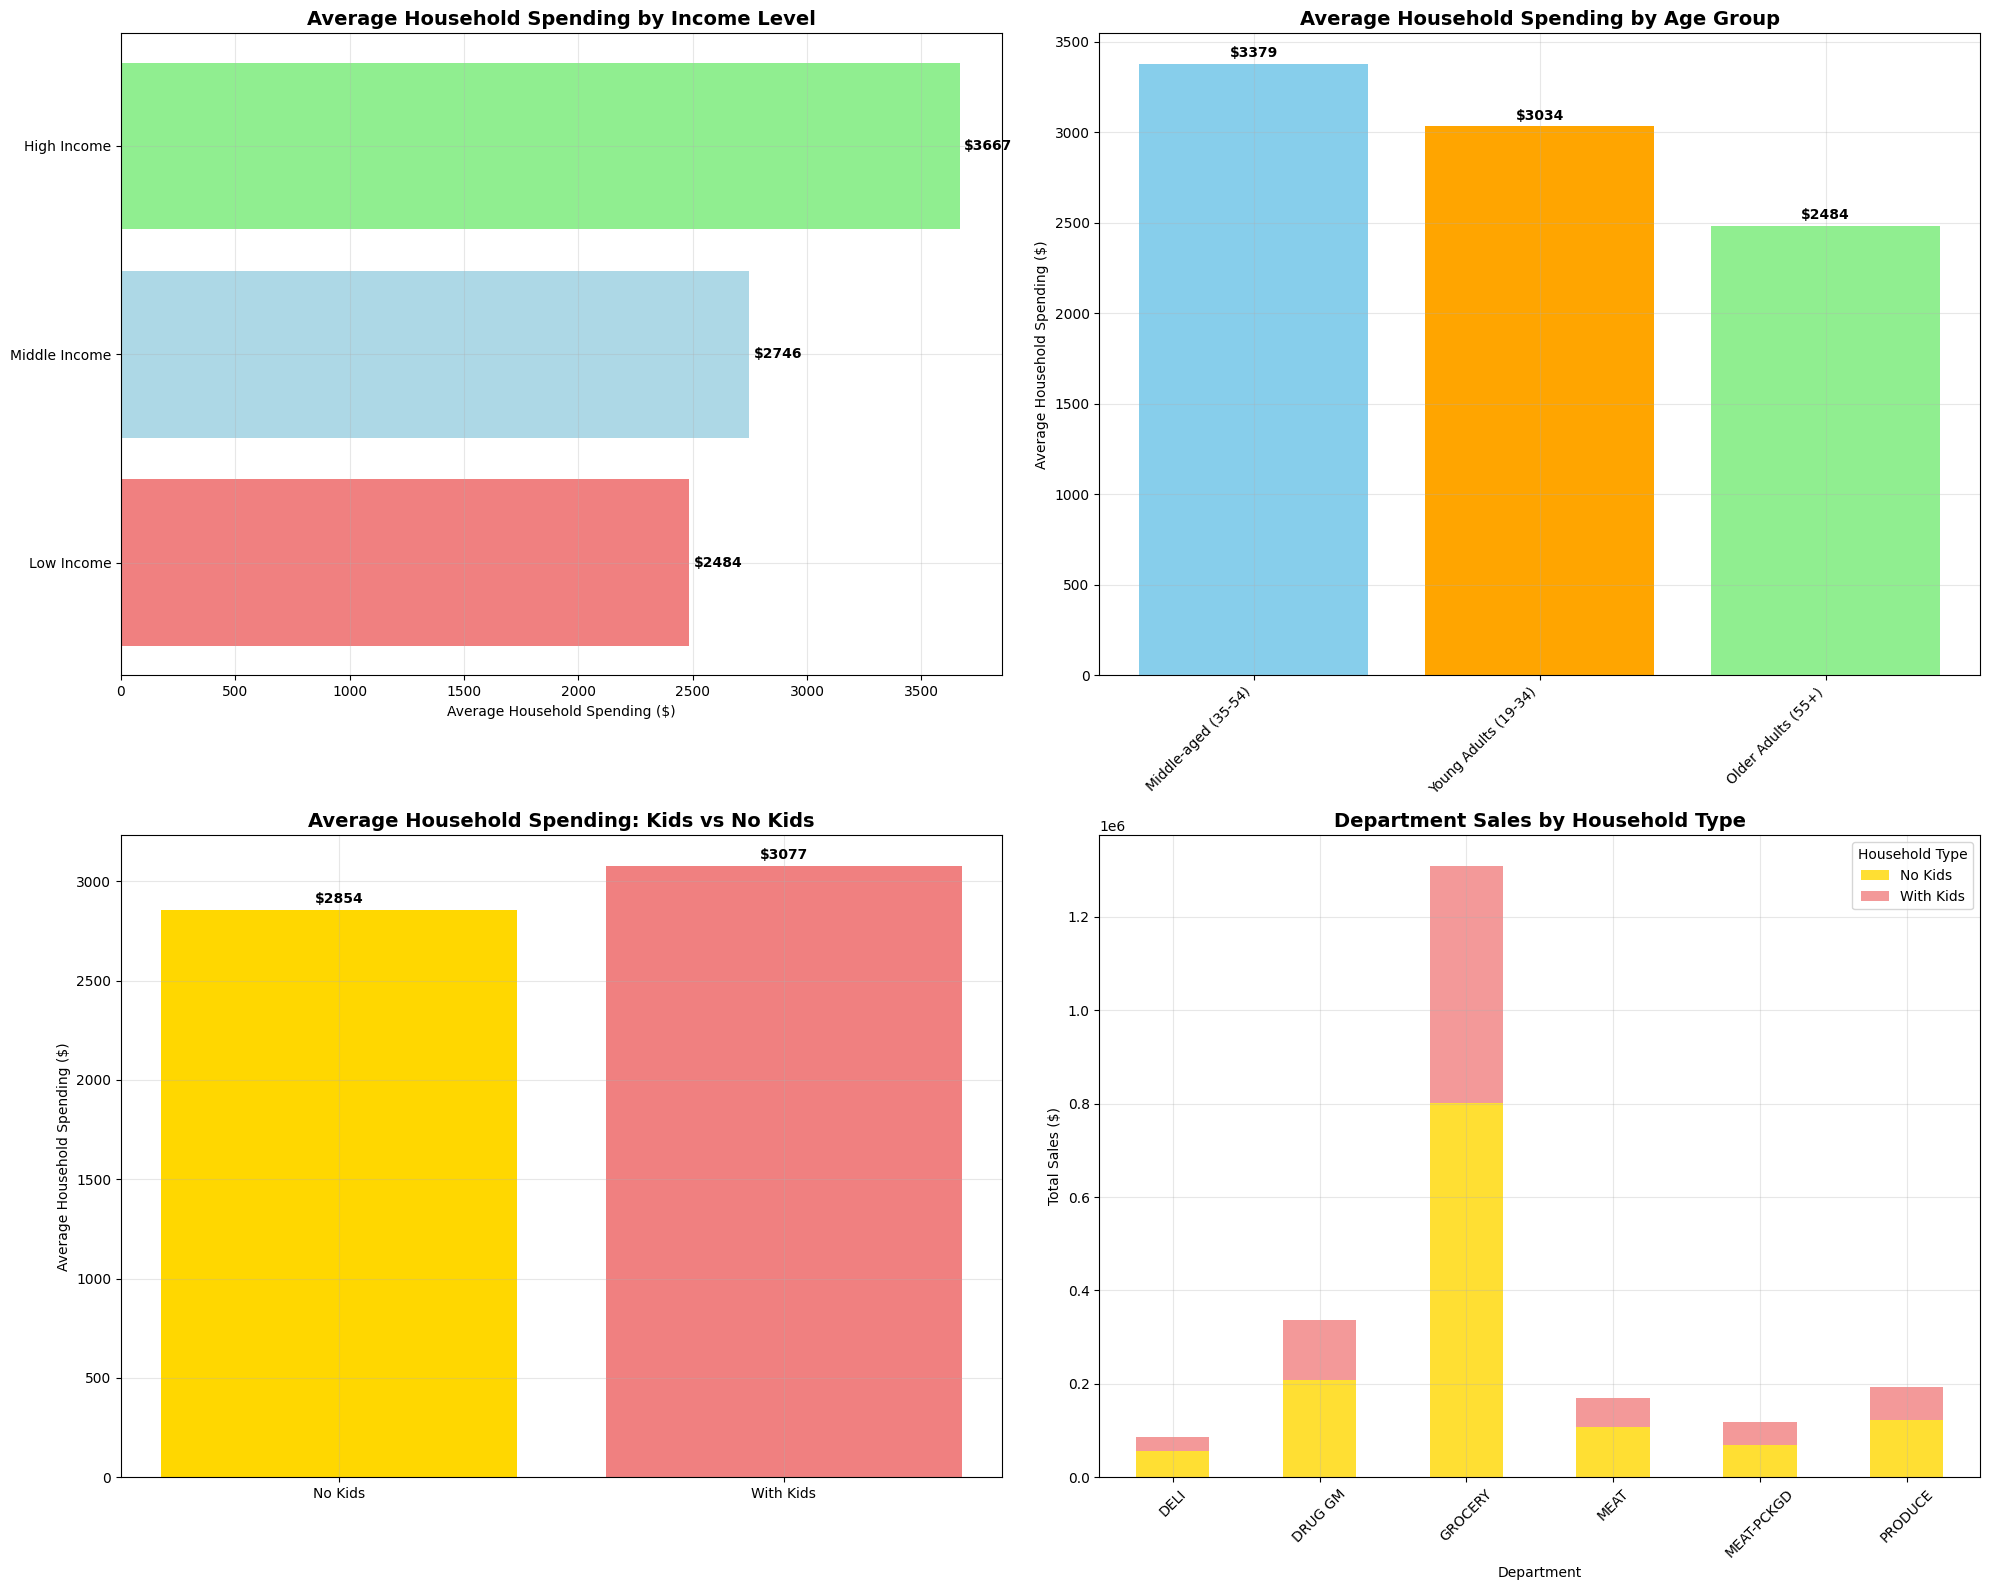

In [9]:
# Create comprehensive visualization of demographic shopping patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Average spending by demographic groups
demo_spending = (
    consumer_transactions
    .groupby(['income_group', 'age_group', 'kids_category', 'household_id'])
    .agg({'sales_value': 'sum'})
    .reset_index()
    .groupby(['income_group', 'age_group', 'kids_category'])
    .agg({'sales_value': 'mean'})
    .reset_index()
)

# Filter out unknown categories for cleaner visualization
demo_spending_clean = demo_spending[
    (demo_spending['income_group'] != 'Unknown') & 
    (demo_spending['age_group'] != 'Unknown')
]

# Pivot for income vs spending
income_spending_pivot = (
    demo_spending_clean
    .groupby('income_group')['sales_value']
    .mean()
    .sort_values(ascending=True)
)

bars1 = ax1.barh(range(len(income_spending_pivot)), income_spending_pivot.values, 
                 color=['lightcoral', 'lightblue', 'lightgreen'])
ax1.set_yticks(range(len(income_spending_pivot)))
ax1.set_yticklabels(income_spending_pivot.index)
ax1.set_xlabel('Average Household Spending ($)')
ax1.set_title('Average Household Spending by Income Level', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 20, bar.get_y() + bar.get_height()/2, 
            f'${width:.0f}', ha='left', va='center', fontweight='bold')

# 2. Spending by age group
age_spending_pivot = (
    demo_spending_clean
    .groupby('age_group')['sales_value']
    .mean()
    .sort_values(ascending=False)
)

bars2 = ax2.bar(range(len(age_spending_pivot)), age_spending_pivot.values, 
                color=['skyblue', 'orange', 'lightgreen'])
ax2.set_xticks(range(len(age_spending_pivot)))
ax2.set_xticklabels(age_spending_pivot.index, rotation=45, ha='right')
ax2.set_ylabel('Average Household Spending ($)')
ax2.set_title('Average Household Spending by Age Group', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 20,
            f'${height:.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Kids vs No Kids comparison
kids_spending_pivot = (
    demo_spending_clean
    .groupby('kids_category')['sales_value']
    .mean()
)

bars3 = ax3.bar(range(len(kids_spending_pivot)), kids_spending_pivot.values, 
                color=['gold', 'lightcoral'])
ax3.set_xticks(range(len(kids_spending_pivot)))
ax3.set_xticklabels(kids_spending_pivot.index)
ax3.set_ylabel('Average Household Spending ($)')
ax3.set_title('Average Household Spending: Kids vs No Kids', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + 20,
            f'${height:.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Top departments by demographic (stacked bar)
top_depts = (
    consumer_transactions
    .groupby('department')['sales_value']
    .sum()
    .nlargest(6)
    .index
)

dept_demo_summary = (
    consumer_transactions[consumer_transactions['department'].isin(top_depts)]
    .groupby(['department', 'kids_category'])['sales_value']
    .sum()
    .unstack(fill_value=0)
)

dept_demo_summary.plot(kind='bar', stacked=True, ax=ax4, 
                      color=['gold', 'lightcoral'], alpha=0.8)
ax4.set_xlabel('Department')
ax4.set_ylabel('Total Sales ($)')
ax4.set_title('Department Sales by Household Type', fontsize=14, fontweight='bold')
ax4.legend(title='Household Type')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Brand Preferences by Demographics

In [10]:
# Analyze brand preferences across demographic segments
brand_demo_analysis = (
    consumer_transactions
    .groupby(['brand', 'income_group', 'kids_category'])
    .agg({
        'sales_value': 'sum',
        'quantity': 'sum',
        'household_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'household_id': 'unique_households'})
)

# Brand preference by income level
brand_income = (
    brand_demo_analysis[brand_demo_analysis['income_group'] != 'Unknown']
    .groupby(['brand', 'income_group'])
    .agg({
        'sales_value': 'sum',
        'unique_households': 'sum'
    })
    .reset_index()
)

# Calculate brand market share by income group
income_totals_brand = brand_income.groupby('income_group')['sales_value'].sum()

print("Brand Performance by Income Group:")
print("=" * 50)

for income_group in ['Low Income', 'Middle Income', 'High Income']:
    print(f"\n{income_group}:")
    income_brand_data = brand_income[brand_income['income_group'] == income_group]
    total_sales = income_totals_brand[income_group]
    
    # Calculate market share
    income_brand_data = income_brand_data.copy()
    income_brand_data['market_share'] = income_brand_data['sales_value'] / total_sales * 100
    
    for i, row in income_brand_data.iterrows():
        print(f"  {row['brand']}: {row['market_share']:.1f}% market share (${row['sales_value']:,.0f})")

# Kids vs No Kids brand analysis
brand_kids = (
    brand_demo_analysis
    .groupby(['brand', 'kids_category'])
    .agg({
        'sales_value': 'sum',
        'unique_households': 'sum'
    })
    .reset_index()
)

kids_totals_brand = brand_kids.groupby('kids_category')['sales_value'].sum()

print(f"\n\nBrand Performance by Household Type:")
print("=" * 50)

for kids_cat in ['With Kids', 'No Kids']:
    print(f"\n{kids_cat} Households:")
    kids_brand_data = brand_kids[brand_kids['kids_category'] == kids_cat]
    total_sales = kids_totals_brand[kids_cat]
    
    # Calculate market share
    kids_brand_data = kids_brand_data.copy()
    kids_brand_data['market_share'] = kids_brand_data['sales_value'] / total_sales * 100
    
    for i, row in kids_brand_data.iterrows():
        print(f"  {row['brand']}: {row['market_share']:.1f}% market share (${row['sales_value']:,.0f})")

Brand Performance by Income Group:

Low Income:
  National: 75.4% market share ($412,829)
  Private: 24.6% market share ($134,696)

Middle Income:
  National: 78.9% market share ($1,041,869)
  Private: 21.1% market share ($278,121)

High Income:
  National: 82.2% market share ($419,081)
  Private: 17.8% market share ($90,780)


Brand Performance by Household Type:

With Kids Households:
  National: 78.8% market share ($718,463)
  Private: 21.2% market share ($193,589)

No Kids Households:
  National: 78.8% market share ($1,155,317)
  Private: 21.2% market share ($310,009)


## Key Insights

This demographic product analysis reveals specific patterns in purchasing behavior across different customer segments based on the Complete Journey dataset:

### **Income-Based Shopping Patterns**
- **Spending correlation**: High income households spend significantly more ($3,953 average) compared to low income ($2,583) and middle income ($2,870) households
- **Universal essentials**: All income groups show 98%+ penetration for core categories like fluid milk products, bread, cheese, and soft drinks
- **Premium preferences**: High income households uniquely prioritize tropical fruit (99.2% penetration) in their top 5 categories
- **Brand preferences**: Higher income correlates with increased national brand preference (Low: 75.4%, Middle: 78.9%, High: 82.2% national brand market share)
- **Department spending**: All income groups prioritize GROCERY, DRUG GM, PRODUCE, and MEAT departments, with high income households notably investing more in DELI ($20,636) relative to other groups

### **Family Structure Impact**
- **Kid-driven categories**: Families with children show dramatically higher penetration in:
  - Toys and games (+20.3% vs no kids households)
  - Molasses/syrup/pancake mixes (+18.1%)
  - Frozen breakfast foods (+16.2%)
  - Frozen ice (+16.1%)
  - Diapers & disposables (+15.8%)
- **Core category dominance**: Families reach near-universal penetration (99.7%) in bread and milk products
- **Adult-oriented preferences**: Households without kids show higher penetration in fuel (-4.8%), liquor (-4.8%), and household cleaning needs (-5.7%)
- **Department patterns**: Families spend more in NUTRITION ($15,136 vs $20,643 absolute), while non-family households dominate overall volume due to higher household count
- **Brand consistency**: Both household types show identical national/private brand splits (78.8% national, 21.2% private)

### **Age Group Preferences**
- **Universal adoption**: Young adults (19-34) achieve 100% penetration in both fluid milk products and soft drinks
- **Generational shifts**: Older adults (55+) prioritize eggs (98.5%) and tropical fruit (97.7%) more than younger groups
- **Spending power**: Middle-aged households (35-54) demonstrate highest spending power ($3,180 average) and purchase volume (1,416 items average)
- **Health consciousness**: Older adults show more conservative spending ($2,425 average) but maintain high penetration in nutritious categories like eggs and vegetables
- **Life stage patterns**: Young adults show high condiment/sauce penetration (96.8%), suggesting more cooking experimentation

### **Department-Level Insights**
- **Universal departments**: GROCERY dominates across all demographics (99%+ penetration), generating 55-60% of total sales across segments
- **Income scaling**: Department spending scales directly with income but maintains consistent ranking (GROCERY > DRUG GM > PRODUCE > MEAT)
- **Family-specific needs**: NUTRITION department shows family preference ($15,136 vs $20,643), likely driven by infant/child products
- **Demographic constants**: All groups prioritize the same top 4 departments, indicating consistent shopping patterns regardless of demographics

### **Product Category Insights**
- **Essential categories**: Fluid milk products, bread, cheese, and soft drinks achieve 96%+ penetration across virtually all demographic segments
- **Premium categories**: Tropical fruit shows strong correlation with both high income (99.2%) and older adults (97.7%)
- **Family necessities**: Clear differentiation in family-oriented categories (breakfast foods, snacks, toys) vs adult-oriented (alcohol, cleaning products)
- **Volume vs penetration**: High-penetration categories like milk and bread also drive significant sales volume ($65K+ each)

### **Strategic Business Applications**

**Targeted Marketing:**
- **Family campaigns**: Focus on breakfast foods, snacks, and convenience items for households with children
- **Premium positioning**: Target tropical fruit, deli products, and national brands to high-income segments
- **Age-specific messaging**: Emphasize health and nutrition for older adults, convenience for young adults
- **Universal promotions**: Use milk, bread, cheese, and soft drinks as traffic drivers across all demographics

**Product Assortment:**
- **Income-based selection**: Stock premium and national brand options in high-income areas
- **Family sections**: Create dedicated family zones featuring breakfast, snack, and child-care products
- **Age-appropriate placement**: Position health-focused products prominently for older adult shoppers
- **Core category optimization**: Ensure robust inventory in the 4 universal categories (milk, bread, cheese, soft drinks)

**Pricing and Promotions:**
- **Income-sensitive pricing**: Develop tiered pricing strategies reflecting the $1,370 spending gap between income groups
- **Family value packs**: Create bulk options for high-penetration family categories
- **Brand strategy**: Promote private label to price-conscious low/middle income segments while maintaining national brand presence for high income
- **Department bundling**: Cross-promote between GROCERY and DRUG GM departments given their universal appeal

**Store Operations:**
- **Layout optimization**: Position essential categories (milk, bread) as anchor points to drive traffic through other departments
- **Inventory planning**: Stock depth should reflect both penetration rates and demographic composition of trade area
- **Seasonal planning**: Prepare for increased family shopping during school periods and holiday seasons
- **Staff allocation**: Ensure adequate coverage in GROCERY and DRUG GM departments during peak family shopping times

This analysis provides data-driven insights for demographic-based customer segmentation, enabling targeted marketing strategies and optimized merchandising decisions based on proven purchasing patterns in the Complete Journey dataset.

## Next Steps

Consider extending this analysis by:
- Examining seasonal variations in demographic purchasing patterns
- Analyzing basket composition and cross-category purchasing by demographics
- Investigating the relationship between demographics and promotional responsiveness
- Studying brand switching behavior across different demographic segments
- Exploring geographic patterns if store location data becomes available